In [1]:
# allows to import own functions
import sys, os, re
root_project = re.findall(r'(^\S*TFM-master)', os.getcwd())[0]
sys.path.append(root_project)

from src.utils.help_func import results_searchcv, make_train_val_test, errors_distribution
from src.features.add_features import features_graph, features_pop

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from scipy.stats import uniform, expon, randint, loguniform
from matplotlib.ticker import PercentFormatter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
import joblib
import json
sns.set()
%matplotlib inline

In [3]:
df_i = pd.read_pickle(f'{root_project}/data/processed/features_model_rev4.pickle')
df_i

,i_country,R0,Tc,Tr,omega,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,limit_deaths,n_closed,react_time,total_infected,total_death,total_removed,betweenness,degree,closeness,country_pop
0,LBN,9.490802,2.214174,21.014286,0.069029,2.918571e+03,114.077951,0.007146,0.005701,0.048225,72,6,23,7.509688e+09,5.191675e+08,7.521476e+09,0.001057,0.270270,0.460581,6.848925e+06
1,KIR,3.161672,6.111805,19.323523,0.012080,1.265010e+05,291.642242,0.003715,0.002368,0.007072,872,2,2,7.166248e+09,8.694994e+07,7.201020e+09,0.000956,0.036036,0.391534,1.158470e+05
2,MOZ,16.439975,1.263448,20.771054,0.046275,8.045407e+04,2297.546954,0.002847,0.001771,0.026642,192,0,22,7.530737e+09,3.532065e+08,7.633573e+09,0.000059,0.054054,0.382759,2.949596e+07
3,ERI,2.141326,1.149404,2.461249,0.014779,5.593643e+03,196.917492,0.006883,0.009034,0.010026,511,9,28,6.401541e+09,9.461014e+07,6.402090e+09,0.000007,0.049550,0.368159,3.213972e+06
4,VCT,9.327237,1.192357,11.121400,0.058201,9.880857e+03,286.248927,0.013316,0.013809,0.044225,958,18,20,7.477989e+09,4.352523e+08,7.478614e+09,0.000035,0.040541,0.312236,1.102100e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229990,DEU,3.785275,4.754930,17.998719,0.292764,4.050000e+01,6.581081,0.065256,0.075975,0.211429,423,18,1,5.351671e+08,1.566770e+08,5.351670e+08,0.051624,0.864865,0.616667,8.292792e+07
229991,MHL,16.557036,0.732844,12.133717,0.957273,1.621672e+06,414061.131148,0.087902,0.079013,0.525821,953,2,14,7.529798e+09,7.285373e+09,7.610553e+09,0.003000,0.036036,0.387435,5.879100e+04
229992,HKG,5.901646,1.641050,9.684893,0.100018,3.583714e+03,306.239024,0.015367,0.012281,0.060047,293,9,20,7.493834e+09,7.499187e+08,7.498033e+09,0.015386,0.378378,0.531100,7.451000e+06
229993,MMR,15.645535,0.928264,14.523181,0.903293,2.151143e+04,17638.718750,0.057810,0.030845,0.449975,390,6,18,7.508318e+09,6.793617e+09,7.520947e+09,0.000069,0.117117,0.393617,5.370840e+07


In [4]:
df_i = df_i.sample(5000) # par entrenar con menos muestras


features = ['Tr', 'inf_pow_1', 'inf_pow_2', 'mort_pow_1', 'mort_pow_2', 'mort_pow_3', 'limit_deaths',
           'n_closed', 'react_time','total_death', 'betweenness', 'degree', 'closeness', 'country_pop']

df = df_i[features]

size_data = int(len(df) / 1000)
print(size_data)
df

X_train_val, y_train_val, X_test, y_test = make_train_val_test(df, out_mode=1)

5
Train_validation set: (4000, 13)
Test set: (1000, 13)


In [5]:
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

param_dist = dict(
    n_estimators=randint(low=1, high=2000),
    max_features=['auto', 'sqrt'],
    max_depth=max_depth,
    min_samples_split=randint(low=2, high=11),
    min_samples_leaf=randint(low=1, high=5),
    bootstrap=[True, False]
)

In [6]:
param_dist

{'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f670a97efd0>,
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f670a90b040>,
 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f670a90b610>,
 'bootstrap': [True, False]}

In [7]:
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), param_dist, cv=3, random_state=42, n_iter=50, n_jobs=-1, verbose=2)

random_search.fit(X_train_val, y_train_val)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f670a90b610>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f670a90b040>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f670a97efd0>},
                   random_state=42, verbose=2)

In [8]:
# joblib.dump(gridsearch, f"{root_project}/models/rfr_rev12.pkl")

In [9]:
# gridsearch = joblib.dump(f"{root_project}/models/rfr_rev12.pkl")

In [10]:
results_searchcv(random_search, X_test, y_test)

Best score:
0.8816924265306102
Best parameters found:
{'bootstrap': True, 'max_depth': 70, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 525}
Score in test:
0.8881713605311565
R^2 in test
0.8881713605311565
MAE in test:
261821035.95386663


In [11]:
max_depth = [int(x) for x in np.linspace(90, 200, num=11)]
max_depth.append(None)

param_dist = dict(
    n_estimators=randint(low=1500, high=2200),
    max_features=['auto'],
    max_depth=max_depth,
    min_samples_split=randint(low=2, high=6),
    min_samples_leaf=randint(low=1, high=3),
    bootstrap=[True]
)

random_search_zoom = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), param_dist, cv=3, random_state=42, n_iter=50, n_jobs=-1, verbose=2)

random_search_zoom.fit(X_train_val, y_train_val)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [90, 101, 112, 123, 134,
                                                      145, 156, 167, 178, 189,
                                                      200, None],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f670a97e340>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f676853a310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f670a90bbb0>},
                   random_state=42, verbose=2)

In [12]:
results_searchcv(random_search_zoom, X_test, y_test)

Best score:
0.8815260320537767
Best parameters found:
{'bootstrap': True, 'max_depth': 156, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1598}
Score in test:
0.8885598143098418
R^2 in test
0.8885598143098418
MAE in test:
261394128.00954872


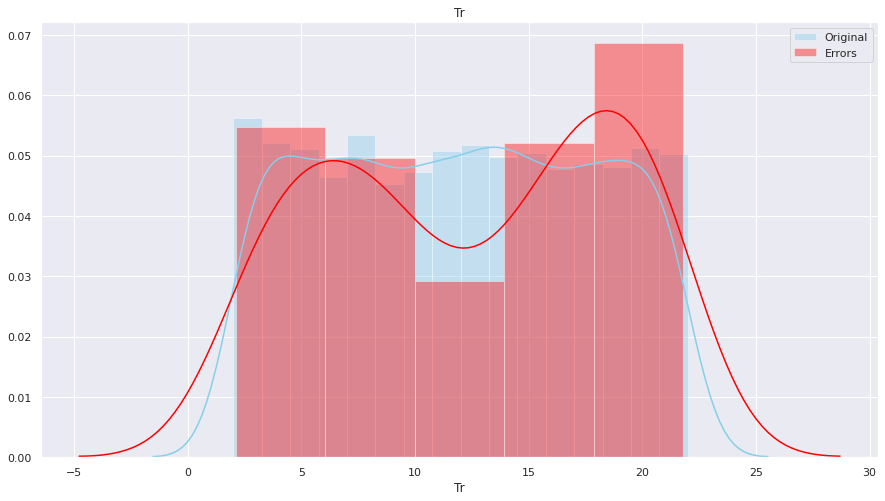

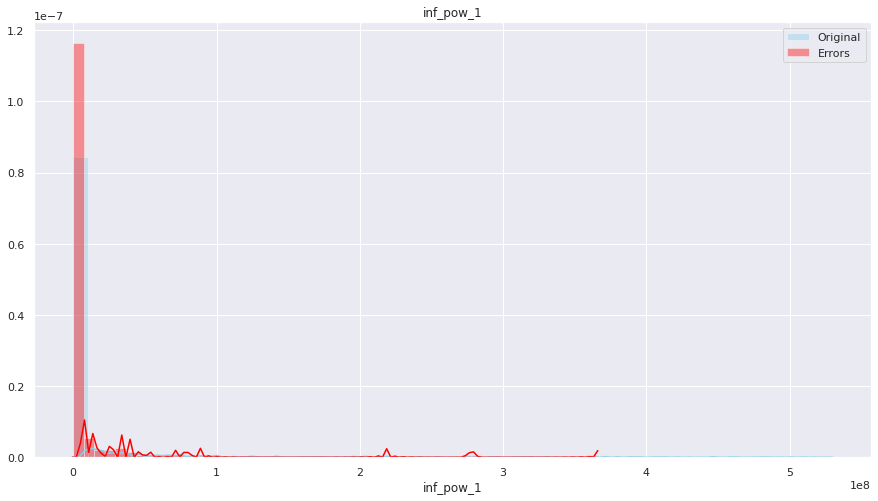

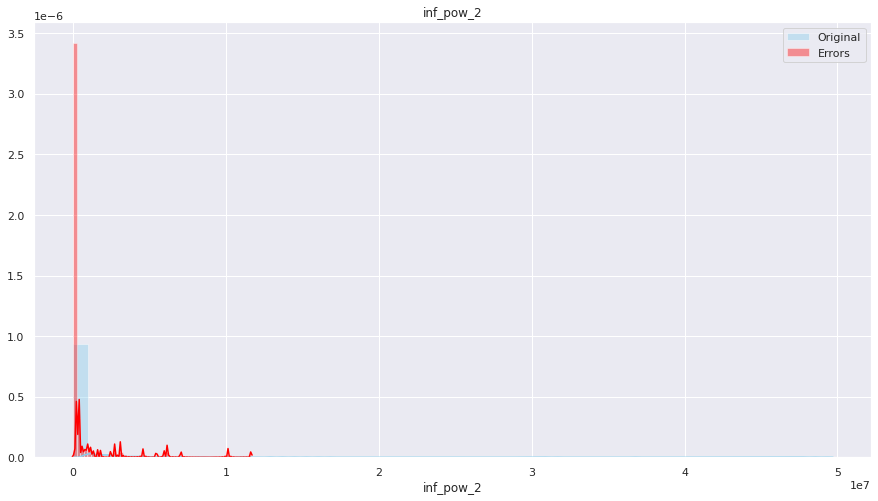

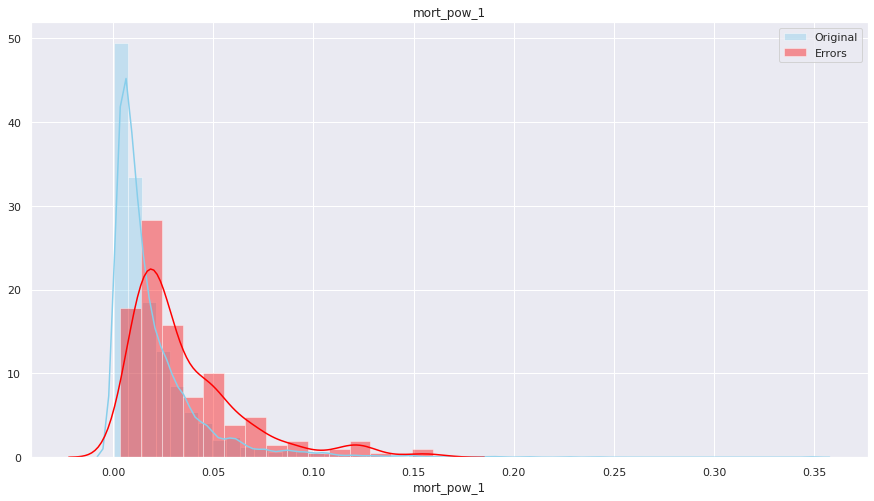

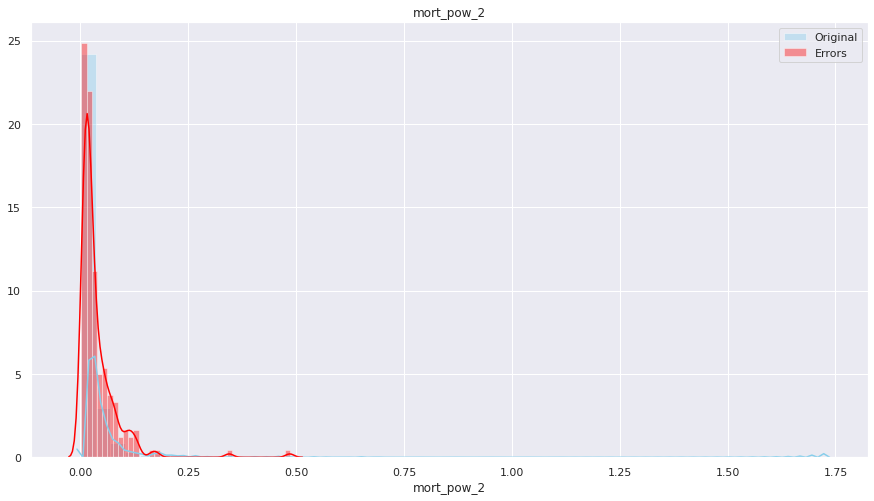

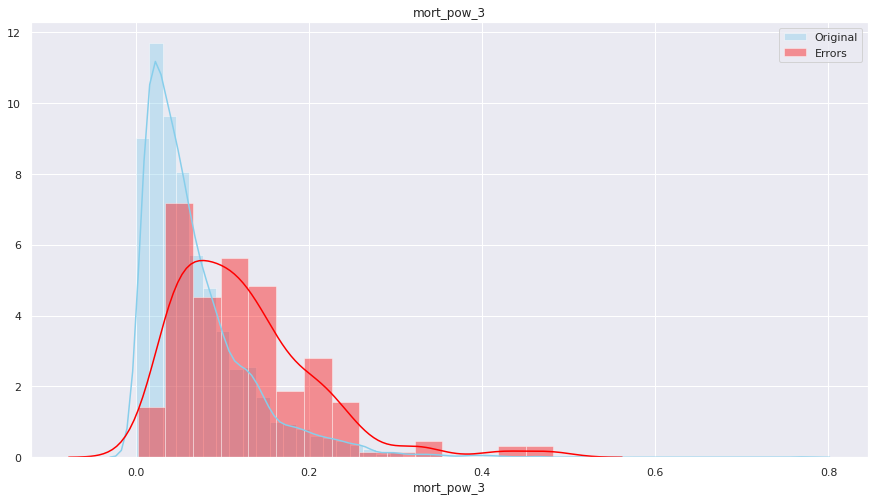

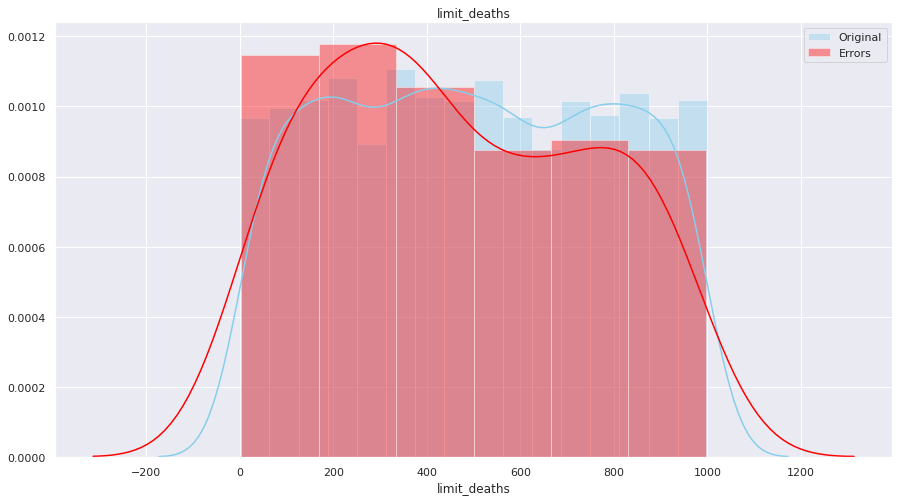

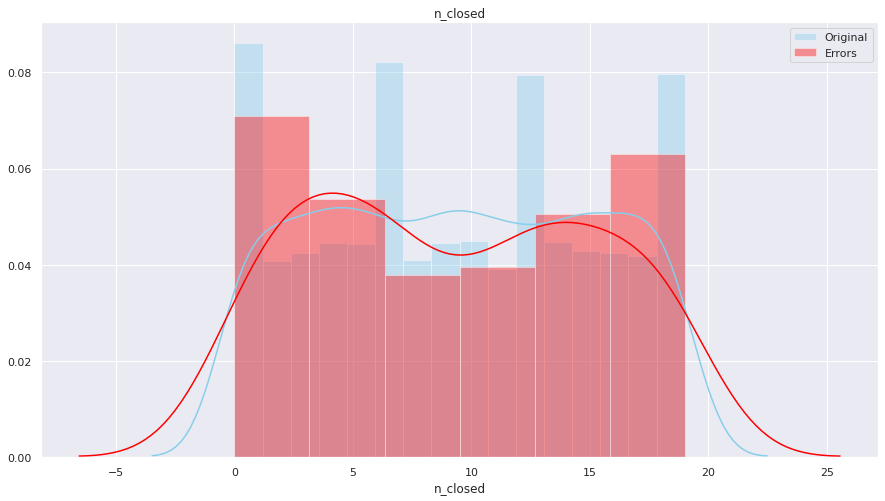

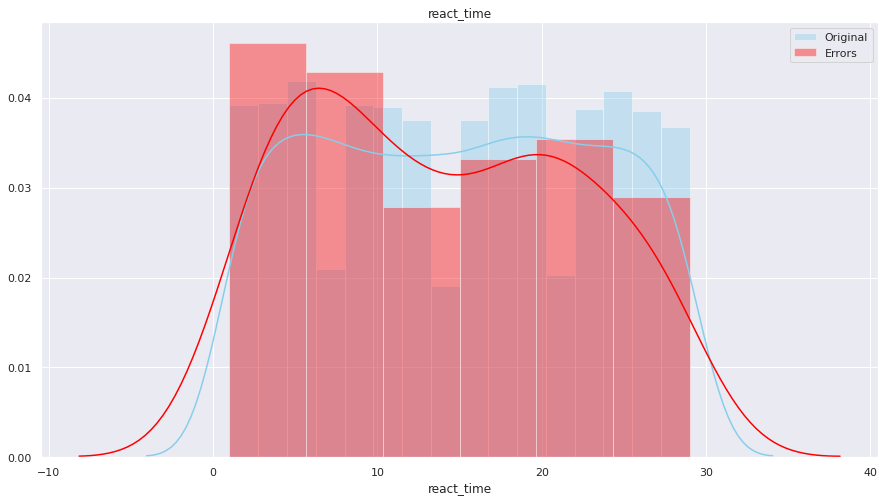

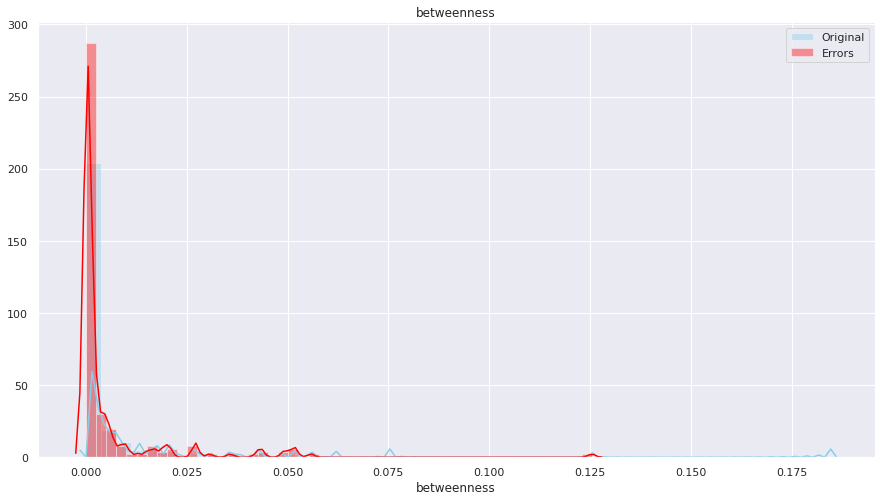

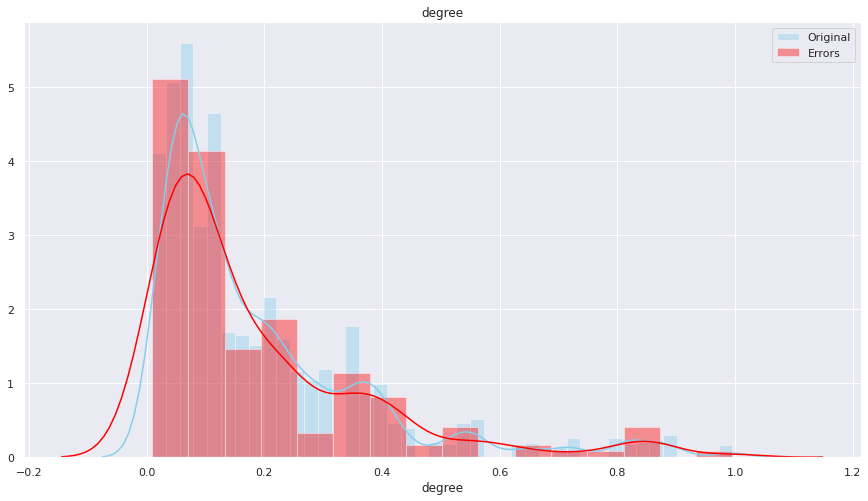

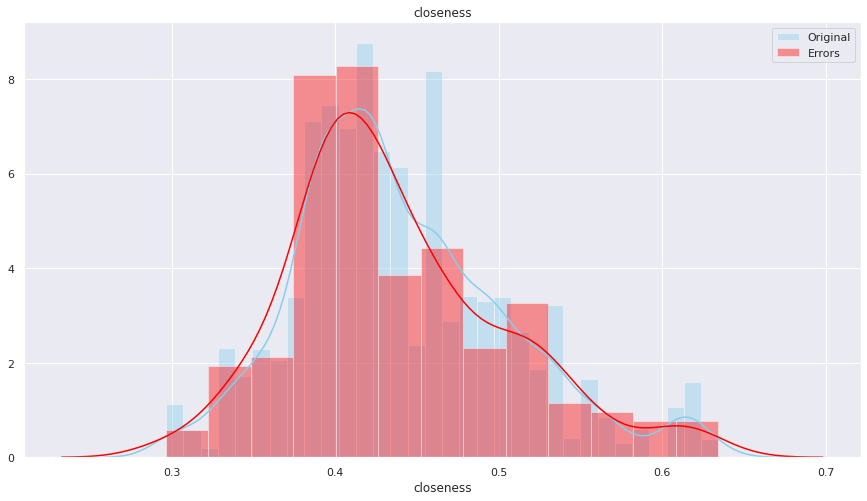

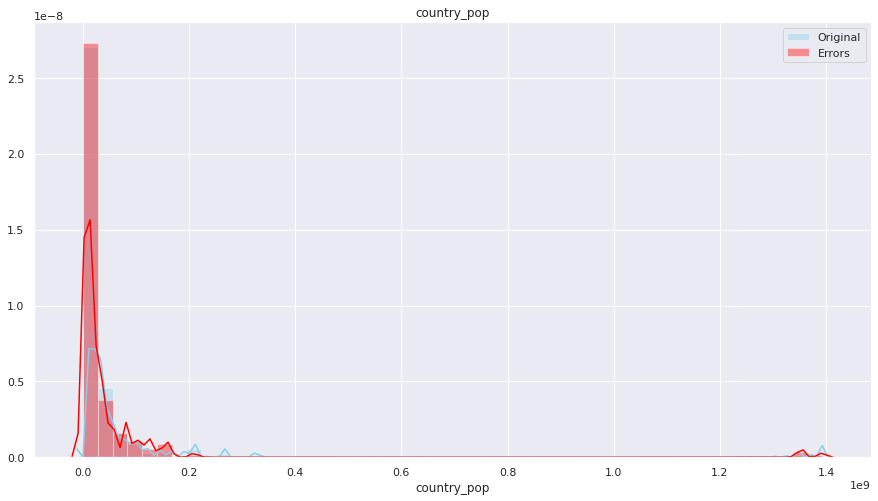

In [14]:
errors_distribution(gridsearch, X_test, y_test, X_train_val, y_train_val)

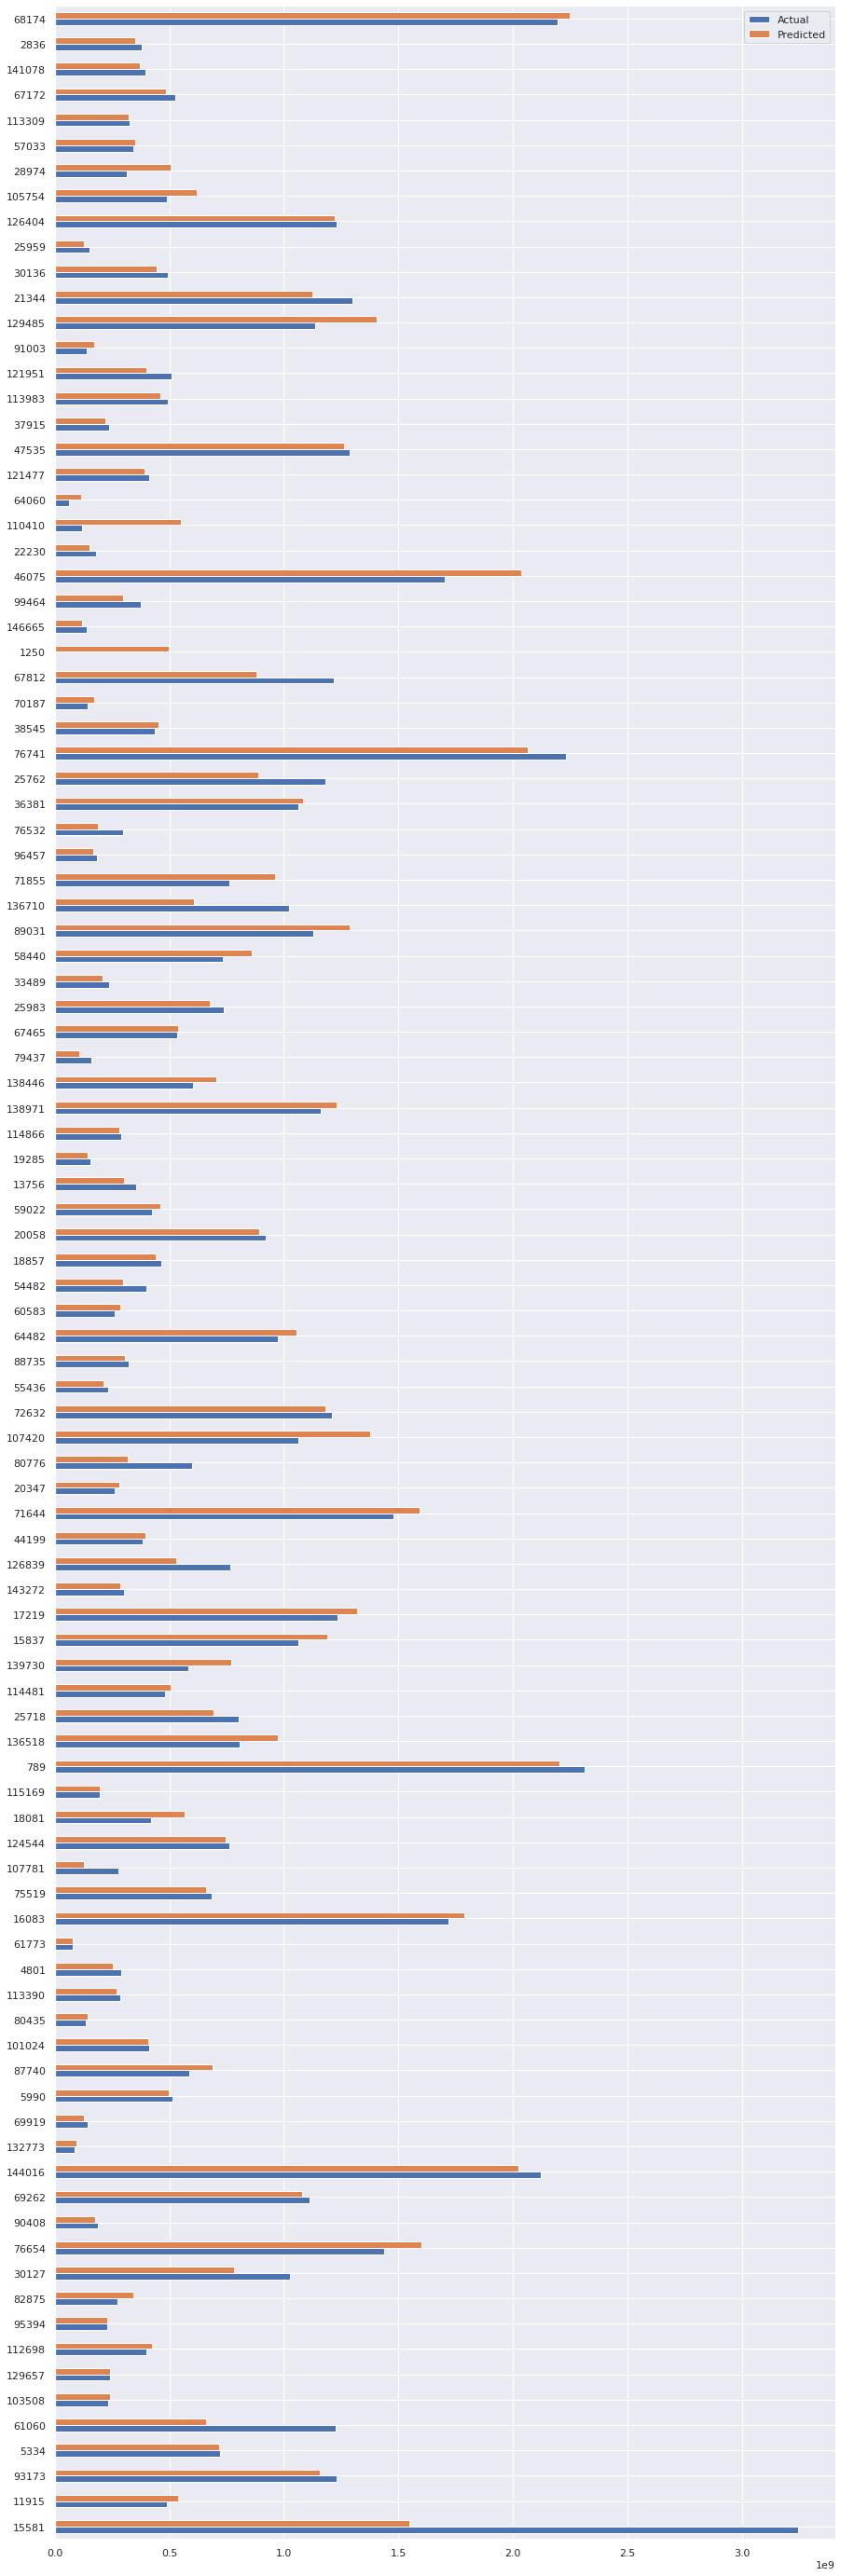

In [15]:
y_predicted = gridsearch.predict(X_test)
df_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})
df_predicted.sample(100).plot(kind='barh', figsize=(15, 50))
plt.show()